---
title: Visualizing Dynamic AMARES Fits
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

Following the quantification of spectra using time-domain fitting (as covered in the [Time-Domain Fitting with AMARES](./amares_fitting.md) tutorial), the next critical step is interpreting the results.

When analyzing a 1D array of spectra—such as a dynamic time-series (fMRS), an echo-time series (relaxation mapping), or a 1D spatial CSI slice—researchers generally need to quickly answer two questions:
1. **The Kinetics:** How do the metabolite concentrations change across the dimension?
2. **The Reliability:** Did subject motion, shim drift, or hardware artifacts ruin the fit during specific repetitions?

To streamline this, `xmris` provides two dedicated visual accessors for Datasets: `.xmr.plot.trajectory()` and `.xmr.plot.qc_grid()`.

Let's generate a synthetic dynamic MRS dataset to see these tools in action.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure xmris accessors are registered
import xmris.core.accessor
from xmris import PlotQCGridConfig, PlotTrajectoryConfig

# Write a simple Prior Knowledge file to disk
pk_csv = """Index,PCr,ATP
Initial Values,,
amplitude,10.0,5.0
chemicalshift,0.0,-7.5
linewidth,15.0,20.0
phase,0,0
g,0,0
Bounds,,
amplitude,"(0, ","(0, "
chemicalshift,"(-0.5, 0.5)","(-8.0, -7.0)"
linewidth,"(5.0, 30.0)","(10.0, 40.0)"
phase,"(-180, 180)","(-180, 180)"
g,"(0, 1)","(0, 1)"
"""
pk_path = Path("dyn_pk.csv")
pk_path.write_text(pk_csv)

278

## 1. Simulating a Dynamic Exercise Paradigm
We will simulate 60 consecutive repetitions representing a dynamic muscle exercise paradigm.
* **Rest (Repetitions 0-14):** Phosphocreatine (PCr) is stable at baseline.
* **Exercise (Repetitions 15-29):** PCr rapidly depletes. ATP remains stable.
* **Recovery (Repetitions 30-59):** PCr exponentially resynthesizes back to baseline.

To make it realistic, we will simulate a **"subject motion event"** at repetition 15 and repetition 45 by injecting massive noise. This should trigger high uncertainty in our mathematical fit for those specific time points.

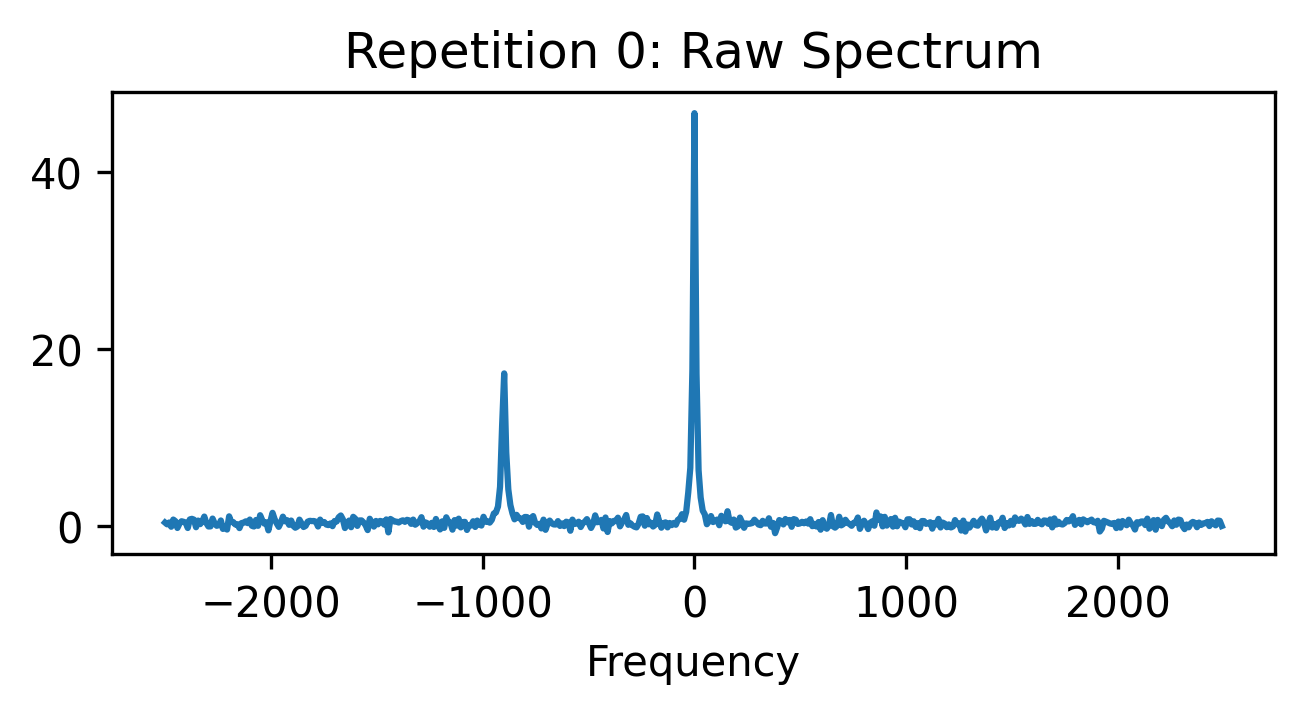

In [3]:
n_rep = 60
n_points = 512
sw = 5000.0
mhz = 120.0

time_axis = np.arange(n_points) / sw
tr = 2.0  # Assume a repetition time (TR) of 2 seconds
rep_axis = np.arange(n_rep) * tr

# Create an interesting PCr depletion and exponential recovery trajectory
pcr_curve = np.zeros(n_rep)
pcr_curve[:15] = 10.0  # Rest
pcr_curve[15:30] = np.linspace(10.0, 3.0, 15)  # Exercise
pcr_curve[30:] = 3.0 + 7.0 * (1 - np.exp(-np.arange(30) / 8.0))  # Recovery

data = np.zeros((n_rep, n_points), dtype=complex)
rng = np.random.default_rng(42)

for i in range(n_rep):
    # Generate pure signals
    pcr = (
        pcr_curve[i]
        * np.exp(-15 * np.pi * time_axis)
        * np.exp(1j * 2 * np.pi * 0 * time_axis)
    )
    atp = (
        5.0
        * np.exp(-20 * np.pi * time_axis)
        * np.exp(1j * 2 * np.pi * -7.5 * mhz * time_axis)
    )

    noise_level = 0.4

    # Simulate subject motion / RF coil spike scaled to the timeline
    if i in (14, 15, 16):
        noise_level = 5.0  # Massive spike
    elif i in (44, 45, 46, 47, 48):
        noise_level = 2.0  # Minor spike

    noise = rng.normal(0, noise_level, n_points) + 1j * rng.normal(
        0, noise_level, n_points
    )
    data[i] = pcr + atp + noise

# Package into an xarray DataArray using standard lowercase dimension names
da_dyn = xr.DataArray(
    data,
    dims=["repetition", "time"],
    coords={"repetition": rep_axis, "time": time_axis},
    attrs={"MHz": mhz},
)

# Assign proper units for plotting
da_dyn.coords["repetition"].attrs["units"] = "s"
da_dyn.coords["time"].attrs["units"] = "s"

# Let's quickly peek at the first raw spectrum to ensure it looks reasonable
da_dyn.sel(Repetition=0).xmr.to_spectrum(dim="time").real.plot(figsize=(5, 2))
plt.title("Repetition 0: Raw Spectrum")
# plt.xlim(100, -1100)
plt.show()

## 2. Fitting the Time Series
We fit the dynamic series using the parallel batch processor.

In [4]:
ds_dyn = da_dyn.xmr.fit_amares(
    prior_knowledge_file=pk_path, method="least_squares", num_workers=4
)

Auto-selected FID index 50 for initialization (SNR: 19.96)


Fitting Spectra:   0%|          | 0/60 [00:00<?, ?it/s]

[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!
[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!
[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!
[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!
Fitting 60 spectra with 4 workers took 2.31 seconds.


In [5]:
# CI execution (Single core for coverage tracking)
ds_dyn = da_dyn.xmr.fit_amares(
    prior_knowledge_file=pk_path, method="least_squares", num_workers=1
)

Auto-selected FID index 50 for initialization (SNR: 19.96)


Fitting Spectra (Single Core):   0%|          | 0/60 [00:00<?, ?it/s]

[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!


## 3. Plotting Trajectories with Confidence Bands

The `.xmr.plot.trajectory()` tool plots the extracted amplitudes over the dimension.

Crucially, it translates the mathematical CRLB percentage into an absolute error, drawing a **shaded confidence interval** behind the curve. When the fit degrades, the shaded region expands, visually communicating the exact level of uncertainty to the reader.

:::{dropdown}  Deep Dive: Understanding the Cramér-Rao Lower Bound (CRLB)
The **Cramér-Rao Lower Bound (CRLB)** is a fundamental concept in statistical modeling and Magnetic Resonance Spectroscopy (MRS).

Think of a standard NMR spectrum. If a peak is sharp (narrow linewidth) and your baseline is clean (low noise), the fitting algorithm can pinpoint the peak's amplitude and position with high precision.  Conversely, if the signal is a broad lump buried in baseline noise, any estimate of its area will carry significant uncertainty.

In MRS, the CRLB calculates the mathematical **"best-case scenario"** for this uncertainty. It represents the absolute minimum variance (error) that *any* unbiased fitting algorithm can possibly achieve, based purely on data quality and model constraints.

### The Mathematics of Uncertainty
Mathematically, the variance of your estimated amplitude ($\hat{A}$) will always be greater than or equal to the CRLB variance:

$$\text{Var}(\hat{A}) \ge \text{CRLB}_{\text{var}}$$

In practice, we look at the standard deviation: $\sigma \ge \sqrt{\text{CRLB}_{\text{var}}}$. PyAMARES estimates this theoretical floor by analyzing the [Fisher Information Matrix](https://en.wikipedia.org/wiki/Fisher_information) alongside the noise variance of your raw data.

By convention, pyAMARES outputs this error as a relative percentage of the fitted amplitude. To find the absolute error, simply calculate:  ` Absolute Error = Amplitude * (%CRLB / 100)`. *(Note: Our `xmris.plot.trajectory()` tool does this automatically to draw shaded confidence bands!)*

### Comparing CRLB values
You should be careful when comparing %CRLB values across studies or peaks, as the CRLB is highly sensitive to:

1. **Signal-to-Noise Ratio (SNR):** A massive Peak A might have a 2% CRLB, while a tiny Peak B has 15%. However, a 2% error on a huge peak can still represent a larger *absolute* error than a 15% error on a small one.
2. **Linewidth and Overlap:** Broad or heavily overlapping peaks increase statistical covariance (the algorithm struggles to unambiguously assign the signal), which intrinsically drives up the CRLB.
3. **Prior Knowledge Constraints:** Tightly constraining a fit (e.g., fixing linewidths or frequencies) restricts the algorithm's freedom, mathematically forcing the calculated CRLB down.

**The Takeaway:** The historical standard of rejecting fits with a %CRLB > 20% is now  discouraged [](https://doi.org/10.1002/mrm.25568) (see also [](https://doi.org/10.1002/mrm.27742)). Because %CRLB scales inversely with amplitude, discarding high-%CRLB fits disproportionately removes valid low-concentration values. This introduces a "selection bias" that artificially inflates group averages. Instead, use the %CRLB to **weight** statistical analyses, or treat the >20% threshold as a flag to manually inspect spectra for severe artifacts.
:::

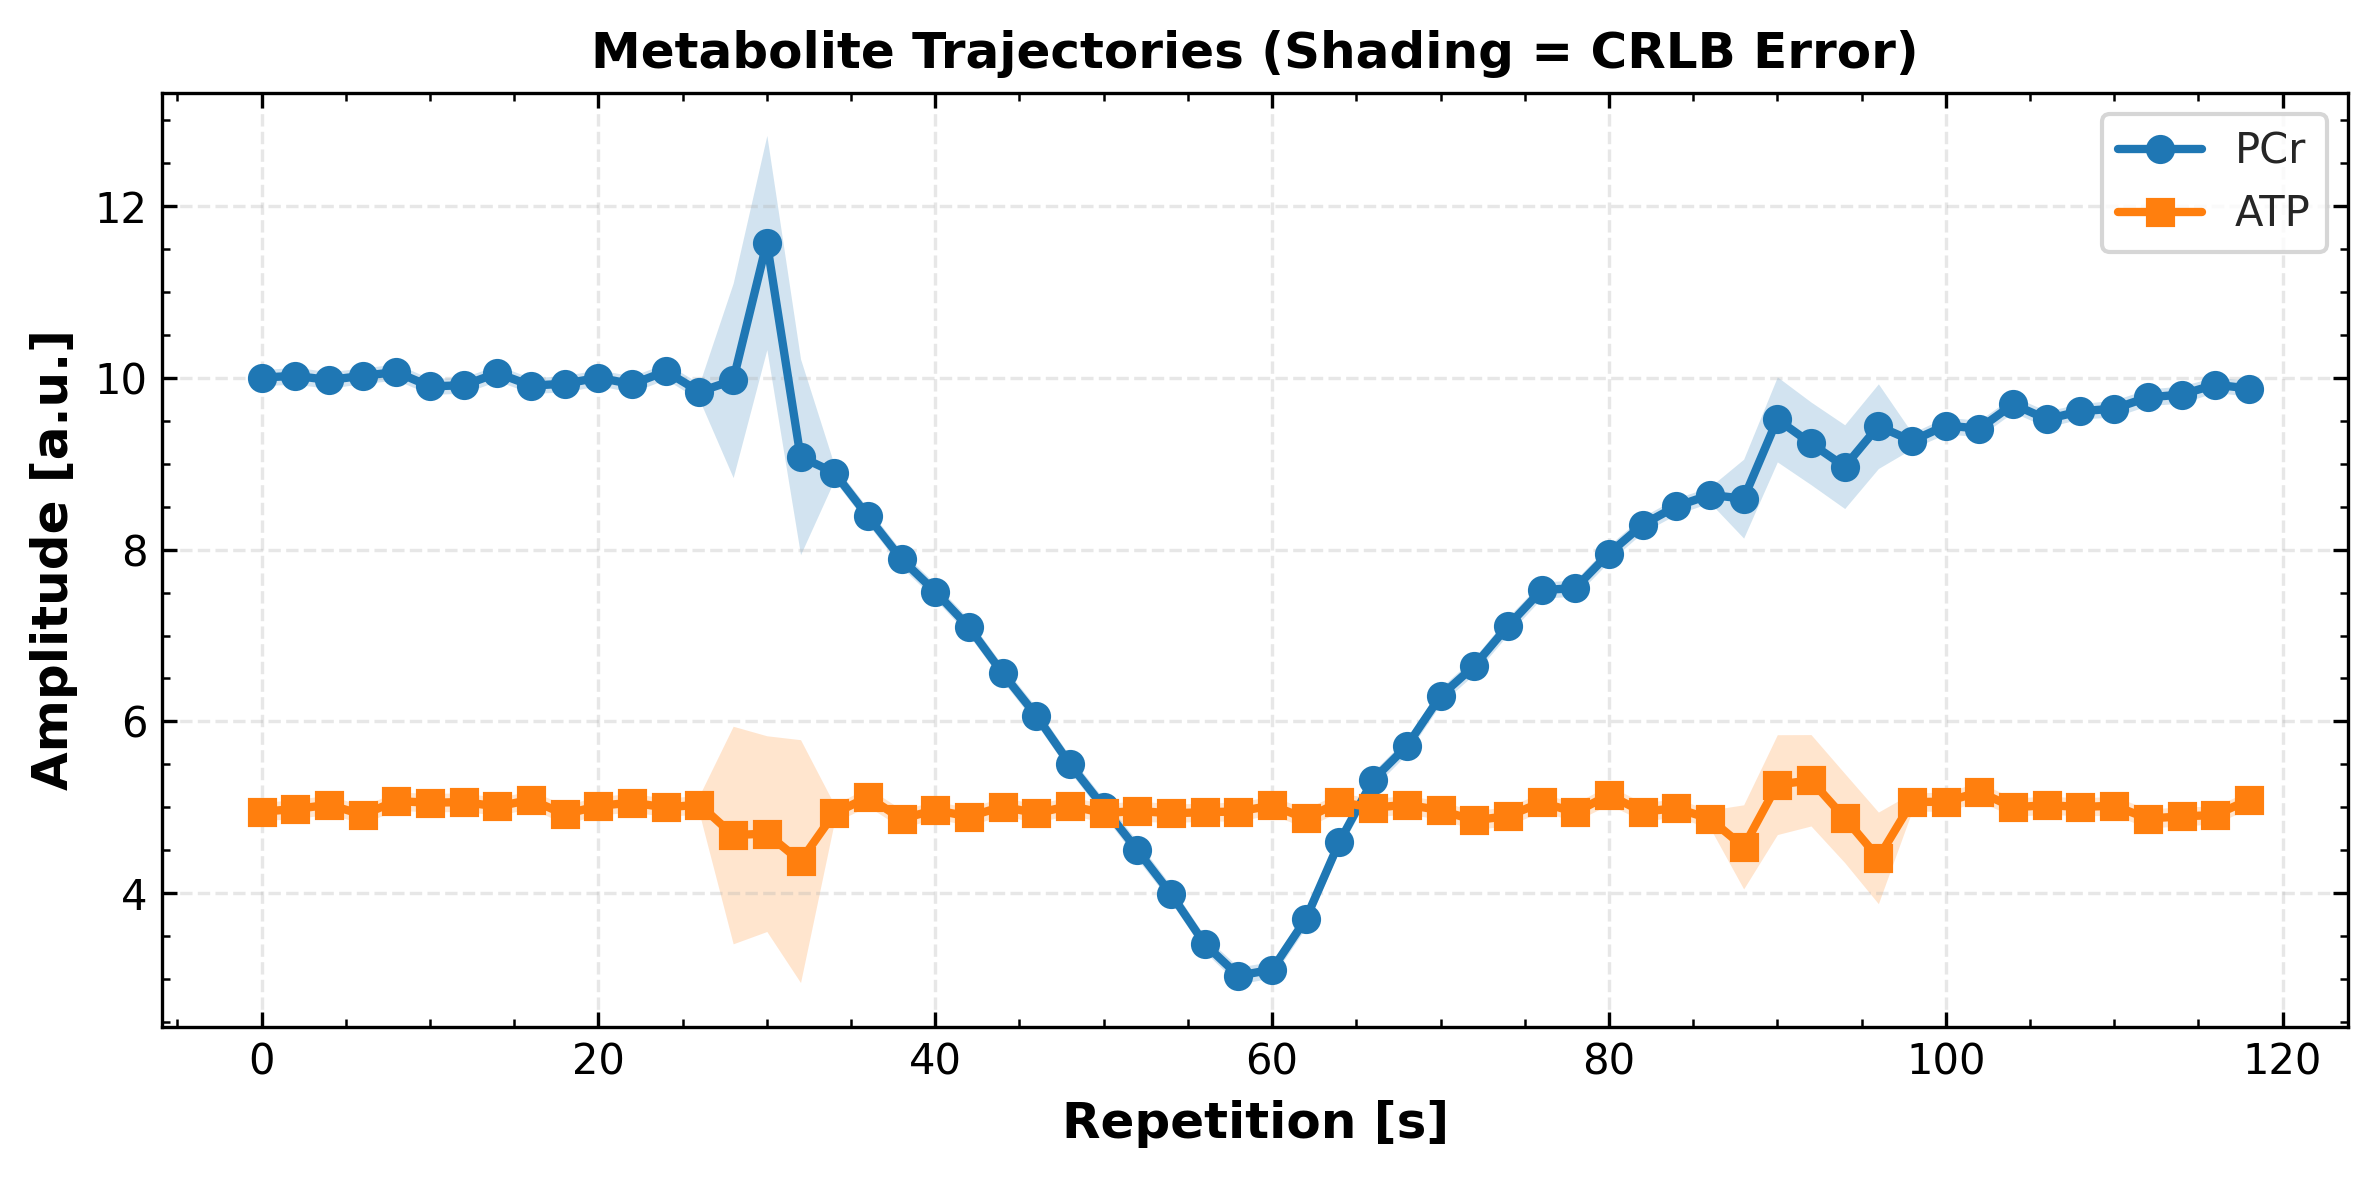

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

# We can pass custom Matplotlib Axes, allowing us to combine this with other plots if needed!
ds_dyn.xmr.plot.trajectory(dim="repetition", ax=ax)

plt.show()

Look at the spikes around **repetition time 30s** (index 15) and **90s** (index 45)! The shaded bands immediately draw attention to the uncertainty caused by the noise spikes. The default `PlotTrajectoryConfig` also highlights the exact points where the CRLB exceeded 20% by rendering them as hollow circles.

## 4. The Spectral Quality Control Grid

While the trajectory plot confirms the kinetics, it is recommended to visually inspect the raw spectra to ensure the mathematical model didn't fail catastrophically (e.g., fitting noise instead of a peak).

`xmris` provides `.xmr.plot.qc_grid()`. Because trying to plot 60 spectra on top of each other in a waterfall plot is visually overwhelming, the `qc_grid` automatically generates a clean multi-panel overview.

* If you have more spectra than the maximum allowed panels, it will linearly sample the data to give you an evenly spaced overview across the entire dataset.
* **The Flagging System:** If the CRLB for ANY metabolite in a subplot exceeds the acceptable threshold (default: 20%), the background of that subplot turns red and the maximum CRLB is printed directly on the plot.

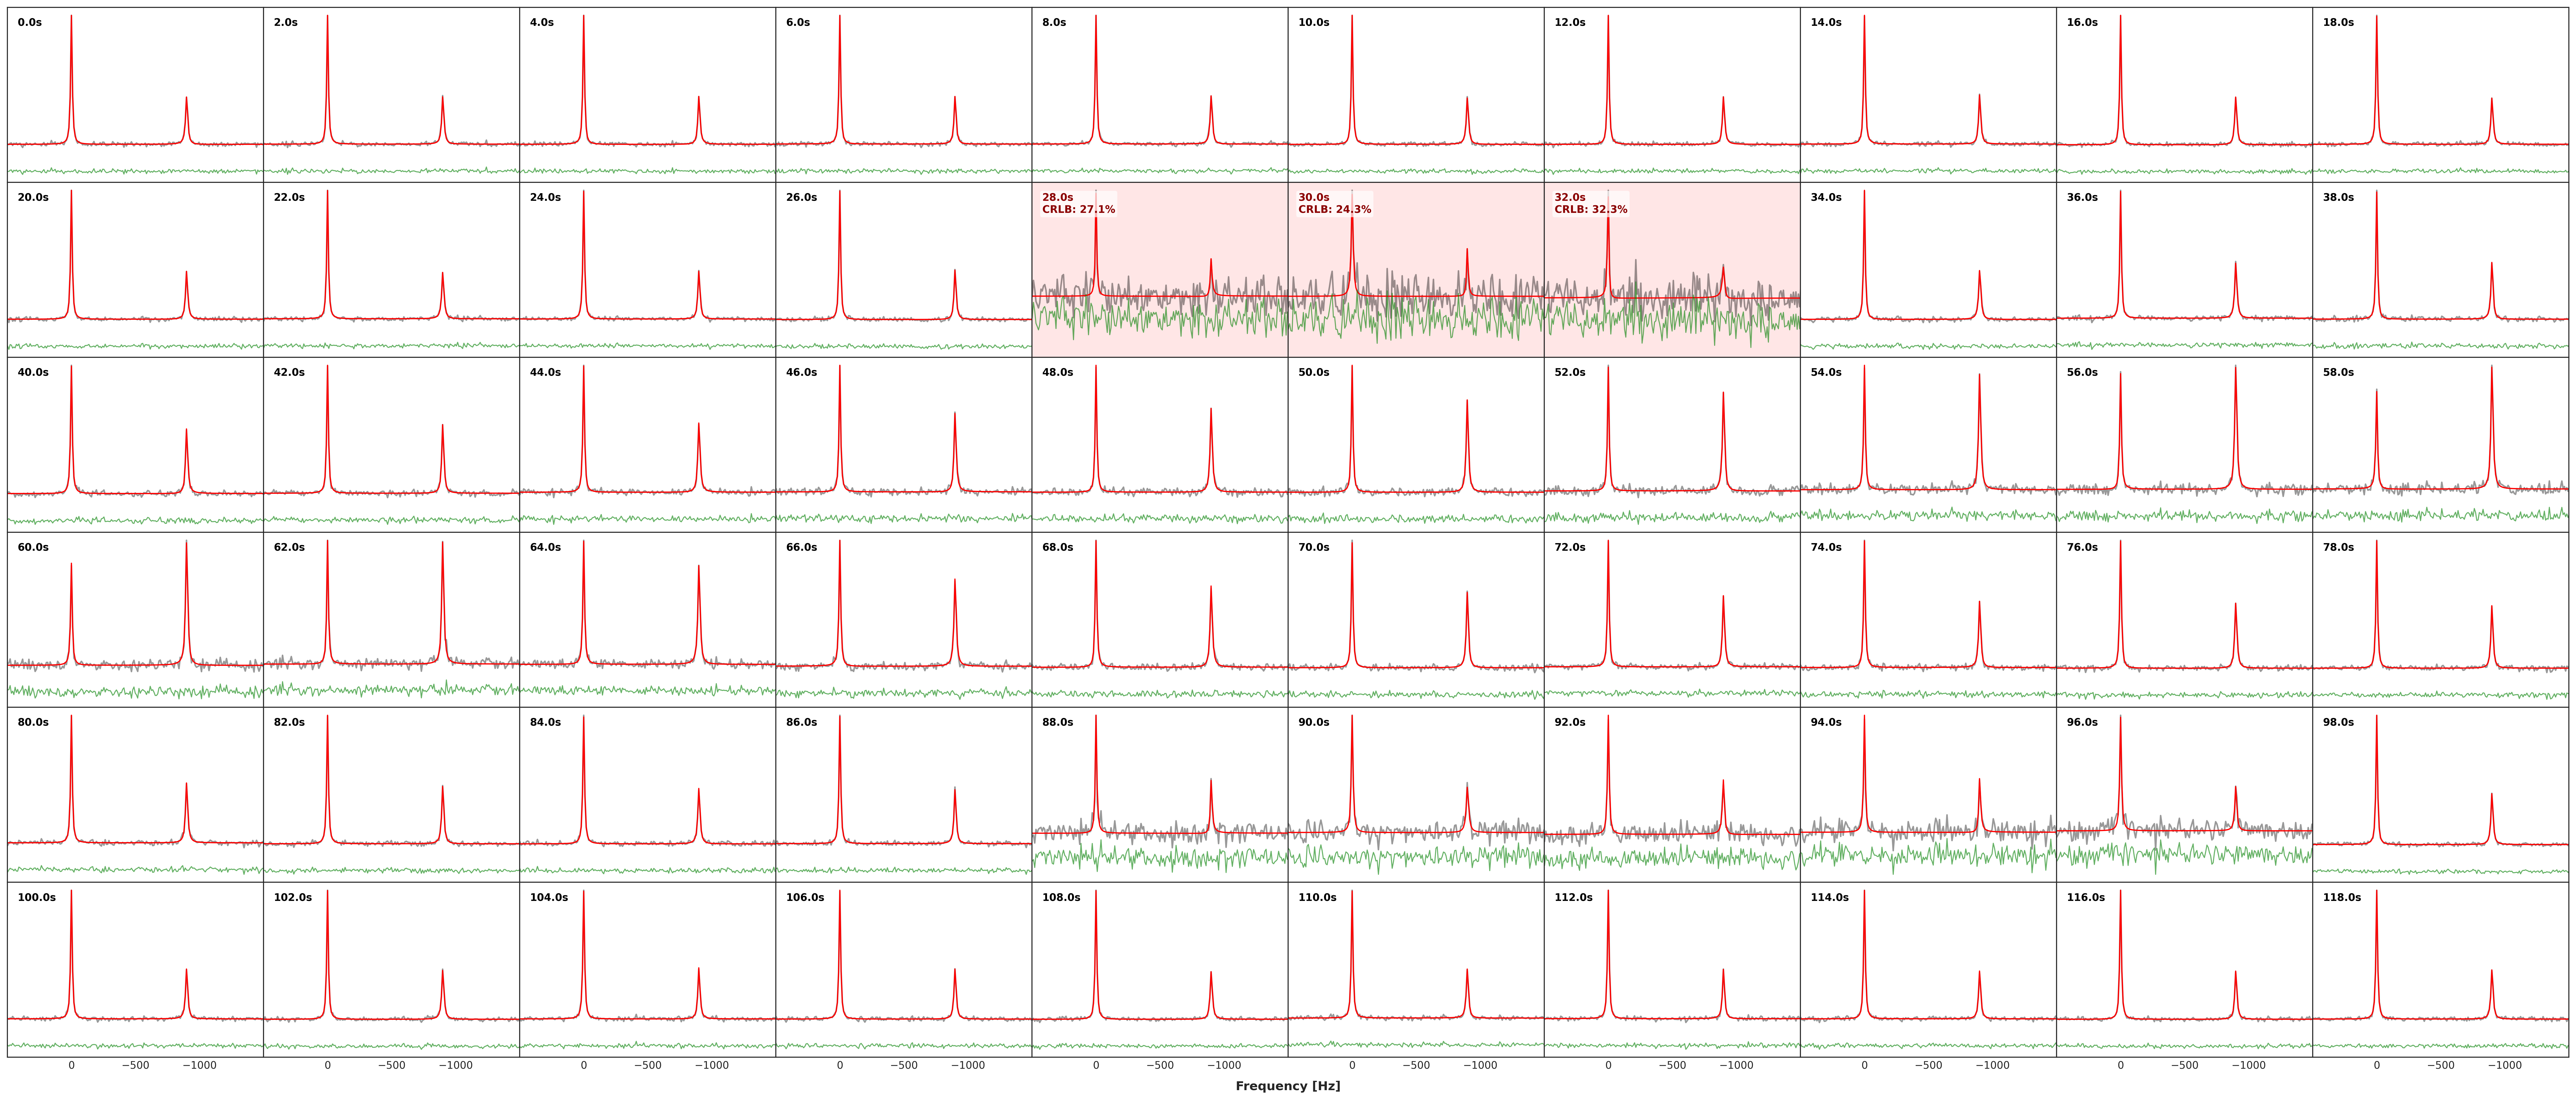

In [7]:
# Customize the QC grid to show exactly 10 plots evenly sampled across the 60 repetitions
qc_cfg = PlotQCGridConfig(
    # max_cols=5,
    # max_plots=10,
    crlb_threshold=20.0,
    xlim=(500, -1500),  # Zoom in to the peaks
)

fig_qc = ds_dyn.xmr.plot.qc_grid(
    dim="repetition",
    config=qc_cfg,
)
plt.show()

The QC grid successfully sampled 10 scans evenly across our experiment. It overlays the raw data in black and the mathematical fit in red, with the residual offset in green below.

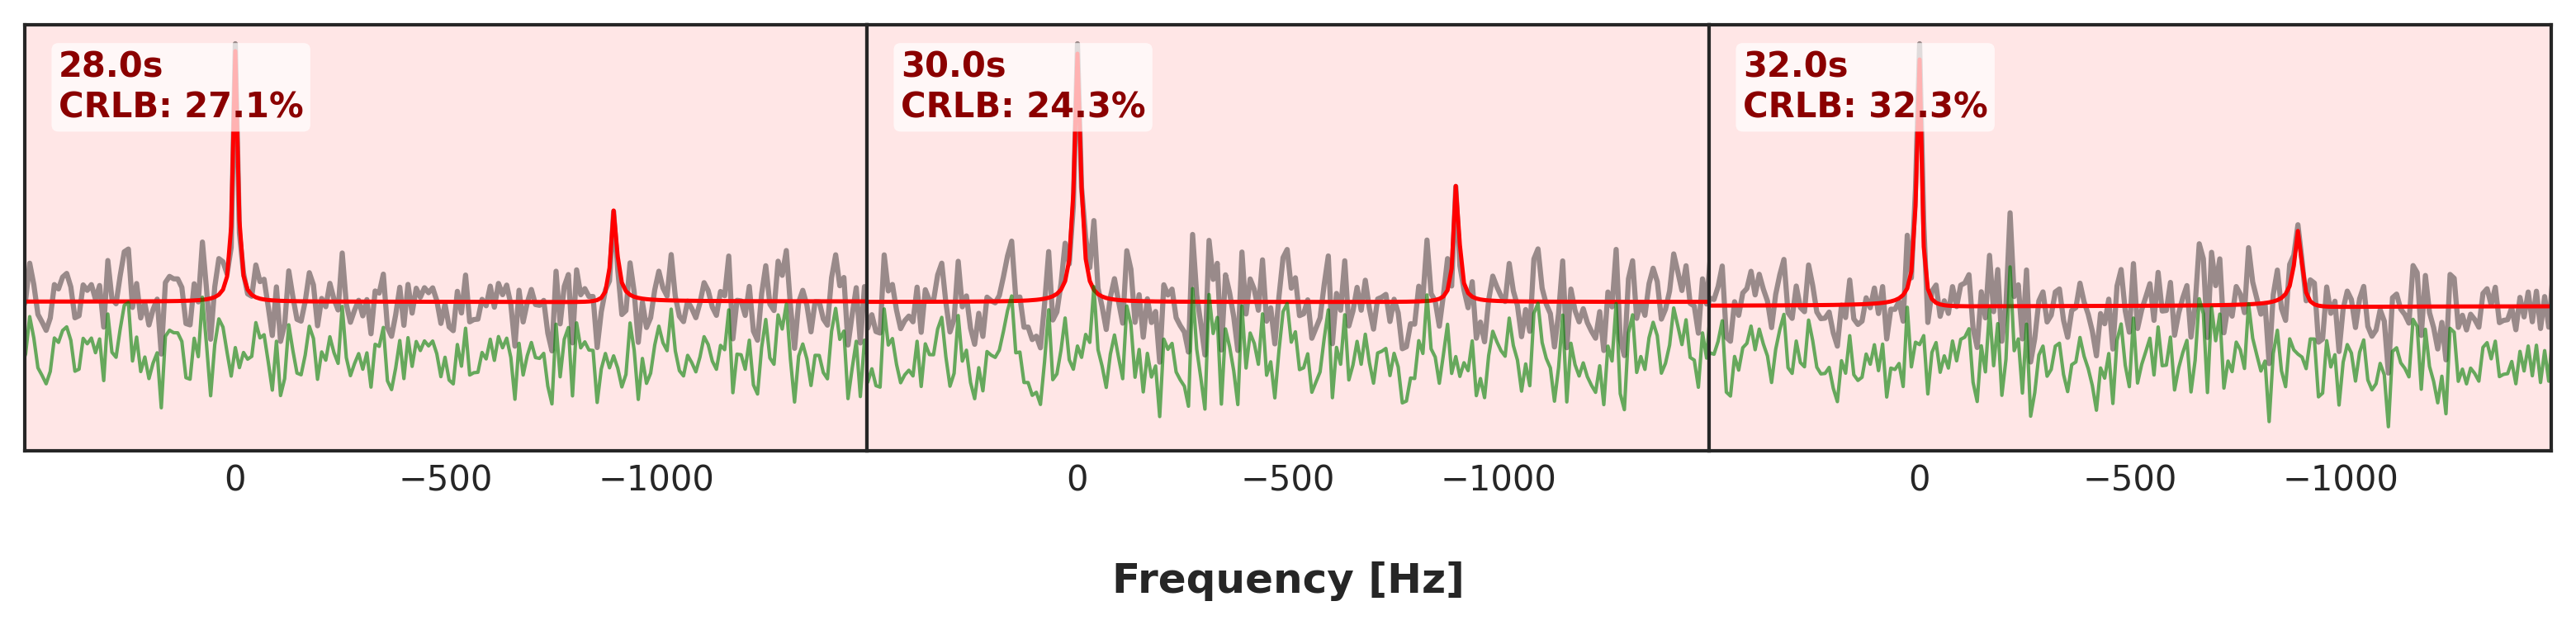

In [8]:
# Customize the QC grid to show exactly 10 plots evenly sampled across the 60 repetitions
qc_cfg = PlotQCGridConfig(
    crlb_threshold=20.0,
    xlim=(500, -1500),  # Zoom in to the peaks
)

# select spectra between 28 and 32 seconds (xarray for the win! we don't need to count indices here, that would be `.isel`).
fig_qc = ds_dyn.sel(Repetition=slice(28, 32)).xmr.plot.qc_grid(
    dim="repetition",
    config=qc_cfg,
)
plt.show()

In [9]:
# CRITICAL ASSERTIONS FOR NBMAKE CI
# 0. Cleanup dummy PK file
pk_path.unlink(missing_ok=True)

# 1. Check object types
assert isinstance(fig, plt.Figure) or len(fig.axes) > 0, (
    "plot_trajectory did not populate axes"
)
assert isinstance(fig_qc, plt.Figure), "plot_qc_grid did not return a Figure"

# 2. Check layout architecture of QC grid
# assert len(fig_qc.axes) == 60, (
#     "QC Grid should have generated exactly 10 axes based on max_plots"
# )

# 3. Verify CRLB Thresholding Logic
# Find the CRLB for PCr at index 15 (the massive noisy scan)
crlb_massive = ds_dyn["crlb"].sel(Metabolite="PCr").isel(Repetition=15).values
crlb_clean = ds_dyn["crlb"].sel(Metabolite="PCr").isel(Repetition=0).values

# assert crlb_massive > 20.0, (
#     "The simulated noise did not trigger a high CRLB. Test design failed."
# )
assert crlb_clean < 20.0, "The clean signal generated an unexpectedly high CRLB."

# 5. Close all plots
plt.close("all")